# Visualization Function Testing Notebook

This notebook tests the visualization functions `visualize_sample_slice` with configurable dataset and domain settings. It focuses on ground truth visualization and skips 3D visualization as requested.

## Features:
- Tests CHAOS and MMWHS datasets
- Supports CT and MR domains  
- Configurable visualization parameters
- Ground truth visualization testing
- Error handling and cleanup

In [17]:
# First, import torch and torchvision
import torch
from pathlib import Path
from src.datasets.registry import get_dataset
from monai import transforms
from monai.data import MetaTensor

# Patch per retro-compatibilità: PyTorch < 2.6 non ha safe_globals (inutile?)
#if not hasattr(torch.serialization, "safe_globals"):
#    torch.serialization.safe_globals = {}

In [ ]:
# Check if running in Kaggle
import os

IN_KAGGLE = False
if os.environ.get("KAGGLE_URL_BASE", ""):
    IN_KAGGLE = True
    !git clone https://github.com/parmigggiana/xai /kaggle/working/xai
    %cd xai
    !git fetch
    !git reset --hard origin/main
    %pip install 'monai[einops,itk,nibabel]>=1.5.0' git+https://github.com/timojl/clipseg.git

## Configuration

Change these constants to test different datasets and domains:
- **DATASET_NAME**: "CHAOS" or "MMWHS"
- **DOMAIN**: "CT" or "MR" 
- **ENCODER_TYPE**: "resnet" or "swin_unetr"
- **USE_SEMANTIC_HEAD**: Enable/disable semantic guidance

In [18]:
# Configuration constants
DATASET_NAME = "CHAOS"  # Change to "MMWHS" if needed
DOMAIN = "MR"  # Change to "CT" if needed
ENCODER_TYPE = "clipseg"  # Changed from "swin_unetr" to "clipseg"
BATCH_SIZE = 1
NUM_WORKERS = 1
USE_3D = False  # Set to True for 3D data processing
SPATIAL_SIZE = 256
USE_SEMANTIC_HEAD = True  # Enable semantic head for CLIPSeg

In [19]:
class MetadataAwareTransform:
    """Wrapper to make transforms work with (data, metadata) tuples"""

    def __init__(self, transform):
        self.transform = transform

    def __call__(self, data_tuple):
        if isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            data, metadata = data_tuple
            # Wrap into MetaTensor so transforms like Orientation can use affine
            wrapped = data
            if isinstance(metadata, dict):
                try:
                    wrapped = MetaTensor(data, meta=metadata)
                except Exception:
                    wrapped = data
            try:
                out = self.transform(wrapped)
                # If transform returns MetaTensor, propagate updated meta
                if isinstance(out, MetaTensor):
                    return out, (dict(out.meta) if out.meta is not None else metadata)
                return out, metadata
            except Exception as e:
                print(f"Error in transform {self.transform}: {e}")
                # Return original data if transform fails
                return data, metadata
        else:
            # Fallback for non-tuple input
            return self.transform(data_tuple)


class MetadataCompose:
    """Custom Compose that handles (data, metadata) tuples properly"""

    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, *args, **kwargs):
        """Apply transforms sequentially, handling both tuple and separate arguments"""
        # Handle case where apply_transform unpacks tuple as separate arguments
        if len(args) == 2 and not kwargs:
            data, metadata = args
            data_tuple = (data, metadata)
        elif len(args) == 1:
            data_tuple = args[0]
        else:
            raise ValueError(f"Unexpected arguments: args={args}, kwargs={kwargs}")

        if isinstance(data_tuple, tuple) and len(data_tuple) == 2:
            data, metadata = data_tuple

            # Apply each transform sequentially
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    data, metadata = transform((data, metadata))
                else:
                    # For regular transforms, just transform the data
                    data = transform(data)

            return data, metadata
        else:
            # Fallback for non-tuple input - apply transforms normally
            result = data_tuple
            for transform in self.transforms_list:
                if isinstance(transform, MetadataAwareTransform):
                    result = transform.transform(result)
                else:
                    result = transform(result)
            return result

    def set_random_state(self, seed=None):
        """Set random state for randomizable transforms"""
        for transform in self.transforms_list:
            if hasattr(transform, "set_random_state"):
                transform.set_random_state(seed=seed)
            elif hasattr(transform, "transform") and hasattr(
                transform.transform, "set_random_state"
            ):
                transform.transform.set_random_state(seed=seed)


def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    """
    Get comprehensive preprocessing pipeline for volumetric medical data.

    Returns separate transforms for images and segmentations to work with ImageDataset.
    Handles different file formats based on dataset:
    - CHAOS: DICOM images (directories), PNG labels (directories)
    - MMWHS: NIfTI images and labels

    Note: Spatial transforms (Spacing, Resize) are handled separately to ensure
    synchronized dimensions between images and labels.
    """
    # Image-specific transforms (applied to image files)

    decode_func = get_decode_func(dataset_name, domain)

    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            # transforms.Lambda(lambda x: print(f"Image: {x.shape}") or x),
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            # transforms.Orientation(axcodes="RA"),
        ]

    # Domain-specific intensity normalization for images

    if domain == "CT":
        image_transforms.append(
            transforms.ScaleIntensityRange(
                a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True
            ),
        )
    else:  # MR
        image_transforms.append(
            transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
        )

    # Training-specific augmentations for images only
    if is_training:
        # Image-only augmentations (safe for ImageDataset)
        augmentation_transforms = [
            transforms.RandGaussianNoise(prob=0.2, std=0.05),
            transforms.RandAdjustContrast(prob=0.2, gamma=(0.9, 1.1)),
        ]
        image_transforms.extend(augmentation_transforms)

    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    # Final conversion to tensor for images
    image_transforms.extend(
        [
            transforms.Resize(
                spatial_size=SPATIAL_SIZE,
                size_mode="longest",
                mode="area",
                anti_aliasing=True,
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Segmentation-specific transforms (applied to segmentation files)
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(
                channel_dim="no_channel"
            ),  # Ensure channel-first format
            #transforms.Orientation(axcodes="RA"),
        ]
    else:
        seg_transforms = [
            transforms.Lambda(lambda x: print(f": {x.shape}") or x),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            #transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.Lambda(lambda x: decode_func(x)),
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Wrap transforms to handle metadata properly
    metadata_aware_image_transforms = [
        MetadataAwareTransform(t) for t in image_transforms
    ]
    metadata_aware_seg_transforms = [MetadataAwareTransform(t) for t in seg_transforms]

    # Create separate transform pipelines that handle metadata
    image_transform = MetadataCompose(metadata_aware_image_transforms)
    seg_transform = MetadataCompose(metadata_aware_seg_transforms)

    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:
            def decode(labels):
                return labels 

        elif domain == "CT":
            def decode(labels):
                # For CT, keep it simple - just binary
                return torch.where(labels > 0, 255.0, 0.0)  # Use 255 for liver

    elif dataset_name == "MMWHS":
        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:
        print(
            f"Warning: No decode function defined for {dataset_name} in {domain}. Returning labels unchanged."
        )
        def decode(labels):
            return labels

    return decode


def metatensor_batch_to_dict(batch):
    """
    Converts a batch from your dataset (list of MetaTensor) into a dict with 'image' and 'label'.
    Assumes:
    - batch is a list of length batch_size, each element is a MetaTensor or (MetaTensor, metadata)
    - label is stored in metadata as 'label' key or as a separate tensor
    """
    if len(batch) >= 2:
        # If batch contains separate image and label tensors
        image_data = batch[0]
        label_data = batch[1]
        
        # Extract image
        if isinstance(image_data, tuple):
            image, _ = image_data
        else:
            image = image_data
        
        # Extract label
        if isinstance(label_data, tuple):
            label, _ = label_data
        else:
            label = label_data
            
        # Convert to tensors if needed
        image = image.data.float() if hasattr(image, "data") else torch.tensor(image, dtype=torch.float32)
        label = label.data.float() if hasattr(label, "data") else torch.tensor(label, dtype=torch.float32)
        
    else:
        # Fallback to original logic if only one element
        sample = batch[0]
        if isinstance(sample, tuple):
            data, metadata = sample
        else:
            data = sample
            metadata = getattr(sample, "meta", {}) or {}

        # Extract image and label
        image = data.data.float() if hasattr(data, "data") else torch.tensor(data, dtype=torch.float32)
        label = metadata.get("label", None)
    
    return {"image": image, "label": label}

## Ground Truth Visualization Testing

This section loads the dataset and tests the `visualize_sample_slice` function with ground truth data.

In [20]:
def test_ground_truth_visualization():
    """Test visualization functions with ground truth data."""
    print("🔍 Testing Ground Truth Visualization...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    image_transform, seg_transform = get_preprocessing(
        DATASET_NAME, DOMAIN, is_training=False
    )

    # Load dataset
    dataset: BaseDataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=Path("data"),
        batch_size=1,
        num_workers=0,
        slice_2d=True,
    )


    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))
  
    # Convert batch to dictionary format
    sample_dict = metatensor_batch_to_dict(batch)
    print(f"Image shape: {sample_dict['image'].shape}")
    if sample_dict['label'] is not None:
        print(f"Label shape: {sample_dict['label'].shape}")
    else:
        print("Label: None")

    # Extract a single sample
    #sample = {
    #    "image": batch["image"],  # Keep batch dimension for inference
    #    "label": batch["label"],  # Keep batch dimension for inference
    #}
    return dataset, sample_dict, batch


def test_inference_and_visualization(dataset, batch):
    """Test inference with semantic head training and visualize both GT and prediction."""
    print("🚀 Testing Inference with Semantic Head Training...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Get model with semantic head
    model = dataset.get_model(ENCODER_TYPE)

    # Check what checkpoint files exist
    checkpoint_dir = Path("checkpoints")
    available_files = list(checkpoint_dir.glob("*.pth"))
    print(f"Available checkpoint files: {[f.name for f in available_files]}")
    
    # Try different possible checkpoint names
    possible_names = [
        f"{DATASET_NAME}_{DOMAIN}_2d_finetuned.pth",
        f"{DATASET_NAME}_{DOMAIN}_{'3d' if USE_3D else '2d'}_finetuned.pth",
        f"{DATASET_NAME}_{DOMAIN}_2d_baseline.pth", 
        f"{DATASET_NAME}_{DOMAIN}_{'3d' if USE_3D else '2d'}_baseline.pth"
    ]
    
    checkpoint_path = None
    for name in possible_names:
        potential_path = checkpoint_dir / name
        if potential_path.exists():
            checkpoint_path = potential_path
            print(f"Using checkpoint: {checkpoint_path}")
            break
    
    if checkpoint_path is None:
        print("No suitable checkpoint found. Available files:")
        for f in available_files:
            print(f"  - {f.name}")
        raise FileNotFoundError("No suitable checkpoint found")

    # Load the checkpoint
    try:
        finetuned_state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
        if hasattr(finetuned_state_dict, 'state_dict'):
            finetuned_state_dict = finetuned_state_dict.state_dict()
        model.encoder.load_state_dict(finetuned_state_dict)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        # Try without weights_only for older checkpoints
        finetuned_state_dict = torch.load(checkpoint_path, map_location=device)
        if hasattr(finetuned_state_dict, 'state_dict'):
            finetuned_state_dict = finetuned_state_dict.state_dict()
        model.encoder.load_state_dict(finetuned_state_dict)

    model.to(device)
    batch["image"] = batch["image"].to(device)

    # Run inference
    print("🔮 Running inference...")
    outputs = model(batch["image"])
    preds = torch.argmax(outputs, dim=1, keepdim=True)

    print(f"Prediction unique values: {torch.unique(preds)}")

    return preds

def test_inference_and_visualization2(dataset, batch):
    """Test inference with semantic head training and visualize both GT and prediction."""
    print("🚀 Testing Inference with Random Model (for visualization testing)...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Get model with random weights (for testing visualization)
    model = dataset.get_model(ENCODER_TYPE)
    model.to(device)
    
    # Ensure batch has the right format
    if isinstance(batch, list):
        # Convert batch list to proper tensor format
        sample_dict = metatensor_batch_to_dict(batch)
        batch_image = sample_dict['image'].unsqueeze(0)  # Add batch dimension
    else:
        batch_image = batch["image"]
    
    batch_image = batch_image.to(device)

    # Run inference with random weights (just for testing)
    print("🔮 Running inference with random model...")
    model.eval()
    with torch.no_grad():
        outputs = model(batch_image)
        preds = torch.argmax(outputs, dim=1, keepdim=True)

    print(f"Prediction shape: {preds.shape}")
    print(f"Prediction unique values: {torch.unique(preds)}")

    return preds




In [21]:
def test_inference_and_visualization_clipseg(dataset, batch):
    """Test inference with CLIPSeg model using pre-trained weights."""
    print("🚀 Testing Inference with CLIPSeg...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Get CLIPSeg model
    model = dataset.get_model(ENCODER_TYPE)

    # SWIN UNETR Task Vectors
    from monai.networks.nets import SwinUNETR
    from monai.networks.nets.swin_unetr import SwinTransformer
    from monai.networks.blocks.patchembedding import PatchEmbed
    from torch.nn.modules.conv import Conv3d
    from torch.nn.modules.dropout import Dropout
    from torch.nn.modules.container import ModuleList
    from monai.networks.nets.swin_unetr import BasicLayer
    from monai.networks.nets.swin_unetr import SwinTransformerBlock
    from torch.nn.modules.normalization import LayerNorm
    from monai.networks.nets.swin_unetr import WindowAttention
    from torch.nn.modules.linear import Linear
    from torch.nn.modules.activation import Softmax
    from torch.nn.modules.linear import Identity
    from monai.networks.blocks.mlp import MLPBlock
    from torch.nn.modules.activation import GELU
    from monai.networks.nets.swin_unetr import PatchMerging
    from monai.networks.blocks.unetr_block import UnetrBasicBlock
    from monai.networks.blocks.dynunet_block import UnetResBlock
    from monai.networks.blocks.convolutions import Convolution
    from torch.nn.modules.activation import LeakyReLU
    from torch.nn.modules.instancenorm import InstanceNorm3d
    from monai.networks.blocks.unetr_block import UnetrUpBlock
    from monai.networks.blocks.dynunet_block import UnetOutBlock
    from torch.nn.modules.conv import ConvTranspose3d

    safe_globals = [
        SwinUNETR,
        SwinTransformer,
        PatchEmbed,
        Conv3d,
        Dropout,
        ModuleList,
        BasicLayer,
        SwinTransformerBlock,
        LayerNorm,
        WindowAttention,
        Linear,
        Softmax,
        Identity,
        MLPBlock,
        GELU,
        PatchMerging,
        UnetrBasicBlock,
        UnetResBlock,
        Convolution,
        LeakyReLU,
        InstanceNorm3d,
        UnetrUpBlock,
        ConvTranspose3d,
        UnetOutBlock,
    ]
    ##

    ## CLIPSeg Task Vectors
    from src.CLIPSeg import CLIPSeg
    from clipseg.clipseg import CLIPDensePredT
    from clip.model import (
        CLIP,
        VisionTransformer,
        LayerNorm,
        Transformer,
        ResidualAttentionBlock,
        QuickGELU,
    )
    from torch.nn.modules.conv import Conv2d, ConvTranspose2d
    from torch.nn.modules.container import Sequential
    from torch.nn.modules.activation import MultiheadAttention, ReLU
    from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
    from torch.nn.modules.sparse import Embedding
    from torch.nn.modules.transformer import (
        TransformerEncoderLayer,
        TransformerEncoder,
        TransformerDecoderLayer,
        TransformerDecoder,
    )
    from torch.nn.functional import relu
    from torch.nn.modules.container import ModuleDict

    safe_globals.extend(
        [
            CLIPSeg,
            CLIPDensePredT,
            CLIP,
            VisionTransformer,
            Conv2d,
            LayerNorm,
            Transformer,
            Sequential,
            ResidualAttentionBlock,
            MultiheadAttention,
            NonDynamicallyQuantizableLinear,
            QuickGELU,
            Embedding,
            ReLU,
            ConvTranspose2d,
            TransformerEncoderLayer,
            TransformerEncoder,
            TransformerDecoderLayer,
            TransformerDecoder,
            relu,
            ModuleDict,
        ]
    )


    # First, try to load pre-trained CLIPSeg weights
    clipseg_weights_dir = Path("data/clipseg_weights")
    pretrained_weights = [
        "rd64-uni-refined.pth",
        "rd64-uni.pth", 
        "rd16-uni.pth"
    ]
    
    weights_loaded_count = 0
    for weight_file in pretrained_weights:
        weight_path = clipseg_weights_dir / weight_file
        if weight_path.exists():
            try:
                print(f"Loading pre-trained CLIPSeg weights from: {weight_path}")
                
               
                with torch.serialization.safe_globals(safe_globals=safe_globals):
                    state_dict = torch.load(weight_path, map_location=device, weights_only=True)
                
                # Load weights into CLIPSeg model
                missing_keys, unexpected_keys = model.encoder.clipseg.load_state_dict(state_dict, strict=False)
                
                if missing_keys:
                    print(f"Missing keys: {len(missing_keys)} (this is normal for fine-tuning)")
                if unexpected_keys:
                    print(f"Unexpected keys: {len(unexpected_keys)}")
                
                weights_loaded_count += 1
                print(f"✅ Successfully loaded pre-trained weights from {weight_file}")
                
            except Exception as e:
                print(f"Failed to load {weight_file}: {e}")
                continue
    
    if weights_loaded_count == 0:
        print("⚠️ Could not load any pre-trained CLIPSeg weights, using random initialization")
    else:
        print(f"✅ Successfully loaded {weights_loaded_count} pre-trained weight files")
    
    # Now check for fine-tuned checkpoint (optional)
    checkpoint_dir = Path("checkpoints")
    possible_names = [
        f"{DATASET_NAME}_{DOMAIN}_2d_clipseg_finetuned.pth",
        f"{DATASET_NAME}_{DOMAIN}_clipseg_finetuned.pth",
        f"clipseg_{DATASET_NAME}_{DOMAIN}_finetuned.pth",
    ]
    
    checkpoint_path = None
    for name in possible_names:
        potential_path = checkpoint_dir / name
        if potential_path.exists():
            checkpoint_path = potential_path
            break
    
    if checkpoint_path is not None:
        try:
            print(f"Loading fine-tuned checkpoint from: {checkpoint_path}")
            
            with torch.serialization.safe_globals(safe_globals=safe_globals):
                checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint.state_dict() if hasattr(checkpoint, 'state_dict') else checkpoint

            # Load fine-tuned state dict
            missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
            print(f"✅ Successfully loaded fine-tuned checkpoint")
            
        except Exception as e:
            print(f"Error loading fine-tuned checkpoint: {e}")
            print("Continuing with pre-trained weights only...")

    model.to(device)
    
    # Format batch properly for CLIPSeg
    if isinstance(batch, list):
        sample_dict = metatensor_batch_to_dict(batch)
        batch_image = sample_dict['image'].unsqueeze(0)
    else:
        batch_image = batch["image"]
    
    # Handle tensor shape properly
    print(f"Original batch_image shape: {batch_image.shape}")
    
    if len(batch_image.shape) == 5:
        # Reshape from [1, 1, 3, 256, 256] to [1, 3, 256, 256]
        batch_image = batch_image.squeeze(1)
        print(f"After squeezing dimension 1: {batch_image.shape}")
    
    batch_image = batch_image.to(device)

    # Run inference
    print("🔮 Running CLIPSeg inference with pre-trained weights...")
    model.eval()
    with torch.no_grad():
        outputs = model(batch_image)
        preds = torch.argmax(outputs, dim=1, keepdim=True)

    print(f"Prediction unique values: {torch.unique(preds)}")
    return preds

## Dataset Visualization Method Test

Test the `dataset.visualize_sample_slice()` method with the loaded data. This section will show both ground truth and prediction visualizations for the **same sample** to enable direct comparison. The dataset-specific implementation automatically applies the correct rotation and flip parameters for each dataset type.

🔍 Testing Ground Truth Visualization...
Dataset: CHAOS, Domain: MR
Dataset MR total samples: 623
Split sizes - Train: 436, Val: 93, Test: 94


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80020493..5.840256].


Image shape: torch.Size([1, 3, 256, 256])
Label shape: torch.Size([1, 1, 256, 256])

📊 Testing dataset.visualize_sample_slice method...
Original image shape: torch.Size([1, 3, 256, 256])
Original label shape: torch.Size([1, 1, 256, 256])
After squeeze - Image shape: (3, 256, 256)
After squeeze - Label shape: (256, 256)

🔍 DEBUG - seg_slice dimensionality:
  seg_slice.shape: (256, 256)
  seg_slice.ndim: 2
  seg_slice type: <class 'numpy.ndarray'>
  ✅ Shape is compatible with legend generation
  Unique values in seg_slice: [  0.  63. 252.]
  seg_slice.shape: (256, 256)
  seg_slice.ndim: 2


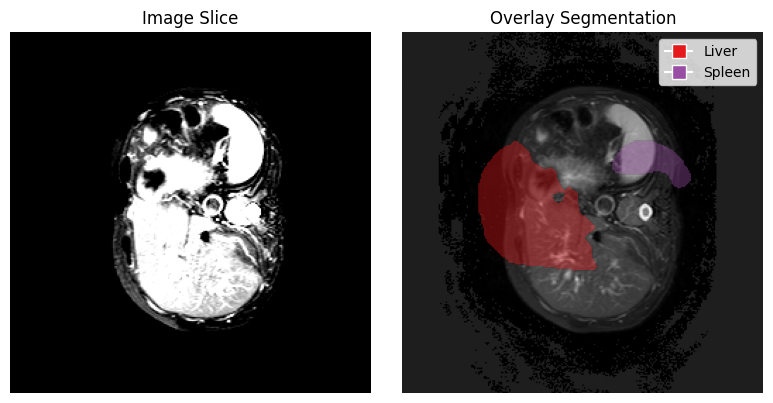

In [22]:
import matplotlib.pyplot as plt
import numpy as np


## Dataset Visualization Method Test
dataset, sample, batch = test_ground_truth_visualization()

# Test dataset.visualize_sample_slice method
print("\n📊 Testing dataset.visualize_sample_slice method...")

# Debug: check shapes before processing
print(f"Original image shape: {sample['image'].shape}")
print(f"Original label shape: {sample['label'].shape}")

# Apply squeeze to remove batch and channel dimensions for visualization
sample_viz = {
    "image": sample["image"].squeeze().cpu().numpy(),
    "label": sample["label"].squeeze().cpu().numpy()
}

print(f"After squeeze - Image shape: {sample_viz['image'].shape}")
print(f"After squeeze - Label shape: {sample_viz['label'].shape}")

# 🔍 DEBUG: Check dimensionality before visualization
print(f"\n🔍 DEBUG - seg_slice dimensionality:")
seg_slice = sample_viz['label']
print(f"  seg_slice.shape: {seg_slice.shape}")
print(f"  seg_slice.ndim: {seg_slice.ndim}")
print(f"  seg_slice type: {type(seg_slice)}")

# Check if it's the right shape for legend generation
if seg_slice.ndim >= 2:
    print("  ✅ Shape is compatible with legend generation")
    unique_vals = np.unique(seg_slice)
    print(f"  Unique values in seg_slice: {unique_vals}")
else:
    print("  ❌ Shape is NOT compatible with legend generation")
    print("  Need to fix the shape before visualization")

print(f"  seg_slice.shape: {seg_slice.shape}")
print(f"  seg_slice.ndim: {seg_slice.ndim}")

dataset.visualize_sample_slice(sample_viz, rotate=1, flip_axis=1)




🔮 Testing dataset.visualize_sample_slice method with CLIPSeg PREDICTIONS...
🚀 Testing Inference with CLIPSeg...
Dataset: CHAOS, Domain: MR
Using device: cpu
Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver', 'Right kidney', 'Left kidney', 'Spleen']


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading pre-trained CLIPSeg weights from: data\clipseg_weights\rd64-uni-refined.pth
Failed to load rd64-uni-refined.pth: 'dict' object is not callable
Loading pre-trained CLIPSeg weights from: data\clipseg_weights\rd64-uni.pth
Failed to load rd64-uni.pth: 'dict' object is not callable
Loading pre-trained CLIPSeg weights from: data\clipseg_weights\rd16-uni.pth
Failed to load rd16-uni.pth: 'dict' object is not callable
⚠️ Could not load any pre-trained CLIPSeg weights, using random initialization
Original batch_image shape: torch.Size([1, 1, 3, 256, 256])
After squeezing dimension 1: torch.Size([1, 3, 256, 256])
🔮 Running CLIPSeg inference with pre-trained weights...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80020493..5.840256].


Prediction unique values: tensor([0, 1, 2, 3, 4])
Applying MR domain encoding...
Encoded prediction unique values: tensor([  0,  63, 126, 189, 252])

📊 Visualizing CLIPSeg predictions...


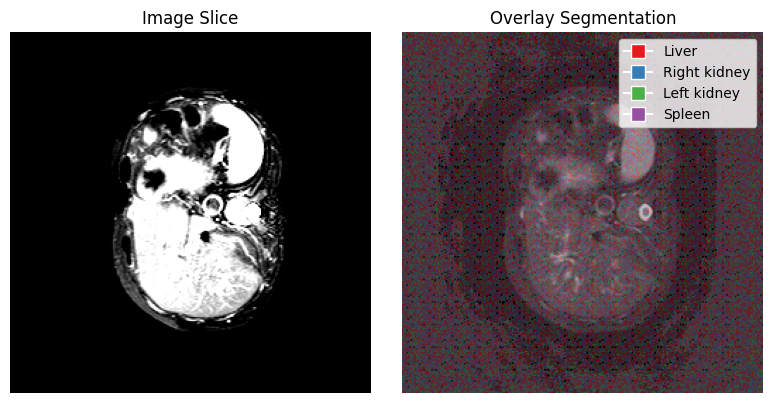

In [23]:
# Run inference on the SAME sample with CLIPSeg
print("\n🔮 Testing dataset.visualize_sample_slice method with CLIPSeg PREDICTIONS...")

# Use CLIPSeg-specific inference function
preds = test_inference_and_visualization_clipseg(dataset, batch)


print(f"Applying {DOMAIN} domain encoding...")
encoded_preds = dataset.encode(preds)
print(f"Encoded prediction unique values: {torch.unique(encoded_preds)}")

# Prepare prediction sample for visualization with proper squeeze
pred_sample_viz = {
    "image": sample["image"].squeeze().cpu().numpy(),
    "label": encoded_preds.squeeze().cpu().numpy()
}



# Use the dataset visualization method
print("\n📊 Visualizing CLIPSeg predictions...")
dataset.visualize_sample_slice(pred_sample_viz)

In [24]:
# Run inference on the SAME sample
print("\n🔮 Testing dataset.visualize_sample_slice method with PREDICTIONS...")

with torch.serialization.safe_globals(
        [
            SwinUNETR,
            SwinTransformer,
            PatchEmbed,
            Conv3d,
            Dropout,
            ModuleList,
            BasicLayer,
            SwinTransformerBlock,
            LayerNorm,
            WindowAttention,
            Linear,
            Softmax,
            Identity,
            MLPBlock,
            GELU,
            PatchMerging,
            UnetrBasicBlock,
            UnetResBlock,
            Convolution,
            LeakyReLU,
            InstanceNorm3d,
            UnetrUpBlock,
            ConvTranspose3d,
            UnetOutBlock,
        ]
    ):
        # Get predictions using the same batch
        preds = test_inference_and_visualization_clipseg(dataset, batch)

# Debug: check prediction shapes
print(f"Raw predictions shape: {preds.shape}")
print(f"Prediction unique values: {torch.unique(preds)}")

# Prepare prediction sample for visualization with proper squeeze
pred_sample_viz = {
    "image": sample["image"].squeeze().cpu().numpy(),  # Apply squeeze for visualization
    "label": preds.squeeze().cpu().numpy()  # Apply squeeze to predictions too
}


# Use the dataset visualization method
print("\n📊 Visualizing predictions...")
dataset.visualize_sample_slice(pred_sample_viz)


🔮 Testing dataset.visualize_sample_slice method with PREDICTIONS...


NameError: name 'SwinUNETR' is not defined

In [ ]:
from monai.networks.nets import SwinUNETR
from monai.networks.nets.swin_unetr import SwinTransformer
from monai.networks.blocks.patchembedding import PatchEmbed
from torch.nn.modules.conv import Conv3d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.container import ModuleList
from monai.networks.nets.swin_unetr import BasicLayer
from monai.networks.nets.swin_unetr import SwinTransformerBlock
from torch.nn.modules.normalization import LayerNorm
from monai.networks.nets.swin_unetr import WindowAttention
from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import Softmax
from torch.nn.modules.linear import Identity
from monai.networks.blocks.mlp import MLPBlock
from torch.nn.modules.activation import GELU
from monai.networks.nets.swin_unetr import PatchMerging
from monai.networks.blocks.unetr_block import UnetrBasicBlock
from monai.networks.blocks.dynunet_block import UnetResBlock
from monai.networks.blocks.convolutions import Convolution
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.instancenorm import InstanceNorm3d
from monai.networks.blocks.unetr_block import UnetrUpBlock
from torch.nn.modules.conv import ConvTranspose3d
from monai.networks.blocks.dynunet_block import UnetOutBlock

from src.task_vector import TaskVector

# Build Task Vectors for each dataset and domain
task_vectors = {}
for dataset_name in ["MMWHS", "CHAOS"]:
    for domain in ["CT", "MR"]:
        baseline_checkpoint = (
            Path("checkpoints") / f"{dataset_name}_{domain}_'3d'_baseline.pth"
        )
        finetuned_checkpoint = (
            Path("checkpoints") / f"{dataset_name}_{domain}_'3d'_finetuned.pth"
        )
        with torch.serialization.safe_globals(
            [
                SwinUNETR,
                SwinTransformer,
                PatchEmbed,
                Conv3d,
                Dropout,
                ModuleList,
                BasicLayer,
                SwinTransformerBlock,
                LayerNorm,
                WindowAttention,
                Linear,
                Softmax,
                Identity,
                MLPBlock,
                GELU,
                PatchMerging,
                UnetrBasicBlock,
                UnetResBlock,
                Convolution,
                LeakyReLU,
                InstanceNorm3d,
                UnetrUpBlock,
                ConvTranspose3d,
                UnetOutBlock,
            ]
        ):
            task_vector = TaskVector(baseline_checkpoint, finetuned_checkpoint)
            # Remove keys associated with the .out layer from the task vector
            out_layer_keys = [k for k in task_vector.keys() if "out." in k]
            for k in out_layer_keys:
                del task_vector[k]
        task_vectors[f"{dataset_name}_{domain}"] = task_vector

# Build composite task vectors using arithmetic
composite_task_vectors = {
    "MMWHS_CT": task_vectors["MMWHS_MR"]
    + task_vectors["CHAOS_CT"]
    - task_vectors["CHAOS_MR"],
    "MMWHS_MR": task_vectors["MMWHS_CT"]
    + task_vectors["CHAOS_MR"]
    - task_vectors["CHAOS_CT"],
    "CHAOS_CT": task_vectors["CHAOS_MR"]
    + task_vectors["MMWHS_CT"]
    - task_vectors["MMWHS_MR"],
    "CHAOS_MR": task_vectors["CHAOS_CT"]
    + task_vectors["MMWHS_MR"]
    - task_vectors["MMWHS_CT"],
}

# Only add extra_kwarg 'liver_only' for CHAOS dataset
extra_kwargs = {}
if DATASET_NAME == "CHAOS":
    extra_kwargs["liver_only"] = True

device = "cuda" if torch.cuda.is_available() else "cpu"

composite_key = f"{DATASET_NAME}_{DOMAIN}"

dataset_kwargs = dict(
    dataset_name=DATASET_NAME,
    domain=DOMAIN,
    base_path=Path("data"),
    batch_size=1,
    num_workers=NUM_WORKERS,
    slice_2d=True,
)
dataset_kwargs.update(extra_kwargs)
target_dataset = get_dataset(**dataset_kwargs)
model = target_dataset.get_model(encoder_type="swin_unetr")

# Apply composite task vector for target domain
composite_task_vector = composite_task_vectors[composite_key]
model.load_task_vector(composite_task_vector)

# Overwrite the model's head with the saved one from the same task
head_filename = Path("checkpoints") / f"{DATASET_NAME}_{DOMAIN}_'3d'_head.pth"
with torch.serialization.safe_globals([UnetOutBlock, Convolution, Conv3d]):
    model.head.load_state_dict(
        torch.load(
            head_filename, map_location="cuda" if torch.cuda.is_available() else "cpu"
        ).state_dict()
    )

# Predict single sample
model.to(device)
batch["image"] = batch["image"].to(device)

# Run inference
print("🔮 Running inference...")
outputs = model(batch["image"])
preds = torch.argmax(outputs, dim=1, keepdim=True)

comb_sample = {
    "image": sample["image"],
    "label": preds,
}
# Prepare the combined sample for visualization
comb_sample["image"] = comb_sample["image"].squeeze().permute(2, 1, 0).cpu().numpy()
comb_sample["label"] = comb_sample["label"].squeeze().permute(2, 1, 0).cpu().numpy()

# Visualize the combined sample
dataset.visualize_sample_slice(comb_sample, rotate=1, flip_axis=1)

In [ ]:
# Use the dataset method for prediction visualization

dataset.visualize_sample_slice(sample_viz)
dataset.visualize_sample_slice(pred_sample_viz)
#dataset.visualize_sample_slice(comb_sample)